In [29]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import joblib
import re

LOAD DATA

In [30]:
# Load the processed application data (Main File)
df_train = pd.read_csv('../data/processed/train_processed.csv')

In [31]:
# Load the NEW Bureau data (History File)
bureau = pd.read_csv('../data/raw/bureau.csv')

In [32]:
print(f"Main Data: {df_train.shape}")
print(f"Bureau Data: {bureau.shape}")

Main Data: (307511, 250)
Bureau Data: (1716428, 17)


In [33]:
df_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100004.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


FEATURE ENGINEERING: AGGREGATE BUREAU DATA

In [35]:
print("Aggregating Bureau History...")

# Helper columns
bureau['CREDIT_ACTIVE_BINARY'] = (bureau['CREDIT_ACTIVE'] == 'Active').astype(int)
bureau['CREDIT_OVERDUE_BINARY'] = (bureau['CREDIT_DAY_OVERDUE'] > 0).astype(int)

# Define the summary stats we want
aggregations = {
    'SK_ID_CURR': ['count'],                # Total past loans
    'AMT_CREDIT_SUM': ['sum', 'mean'],      # Total debt history
    'CREDIT_DAY_OVERDUE': ['max'],          # Worst overdue ever
    'CREDIT_ACTIVE_BINARY': ['mean'],       # % of active loans
    'CREDIT_OVERDUE_BINARY': ['mean']       # % of loans ever overdue
}

# Group by Customer and calculate stats
bureau_agg = bureau.groupby('SK_ID_CURR').agg(aggregations)

# Flatten column names (e.g. from ('AMT','sum') to 'AMT_SUM')
bureau_agg.columns = ['_'.join(col).upper() for col in bureau_agg.columns]
bureau_agg = bureau_agg.reset_index()

# Rename for clarity
bureau_agg = bureau_agg.rename(columns={'SK_ID_CURR_COUNT': 'BUREAU_LOAN_COUNT'})

Aggregating Bureau History...


MERGE

In [36]:
print("Merging data...")
df_final = df_train.merge(bureau_agg, on='SK_ID_CURR', how='left')

# Fill NaNs (Customers with no history get 0s)
new_cols = [col for col in bureau_agg.columns if col != 'SK_ID_CURR']
df_final[new_cols] = df_final[new_cols].fillna(0)

print(f"Final Data Shape: {df_final.shape} (Added {len(new_cols)} new features)")

Merging data...
Final Data Shape: (307511, 256) (Added 6 new features)


PREPARE FOR TRAINING

In [37]:
# Drop ID and Target to make X
X = df_final.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_final['TARGET']

# Clean column names for LightGBM (remove special chars)
X.columns = [re.sub(r'[^\w]', '_', col) for col in X.columns]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print("Training 'Bureau Boost' Model...")

d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test, reference=d_train)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'is_unbalance': True,  # Handle imbalance automatically
    'verbose': -1
}

model = lgb.train(
    params,
    d_train,
    num_boost_round=1000,
    valid_sets=[d_test],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


Training 'Bureau Boost' Model...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[385]	valid_0's auc: 0.769787


RESULTS

In [38]:
# 6. RESULTS
print("------------------------------------------------")
print(f"PREVIOUS BEST SCORE: 0.7692")
print(f"NEW SCORE (AUC):     {model.best_score['valid_0']['auc']:.4f}")
print("------------------------------------------------")


------------------------------------------------
PREVIOUS BEST SCORE: 0.7692
NEW SCORE (AUC):     0.7698
------------------------------------------------


In [39]:
# Save if better
joblib.dump(model, '../models/final_model_lgbm_boosted.joblib')

['../models/final_model_lgbm_boosted.joblib']

SHAP

c:\Users\Ronak Sumrani\My Projects\Credit_Risk_Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Ronak Sumrani\My Projects\Credit_Risk_Project\venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


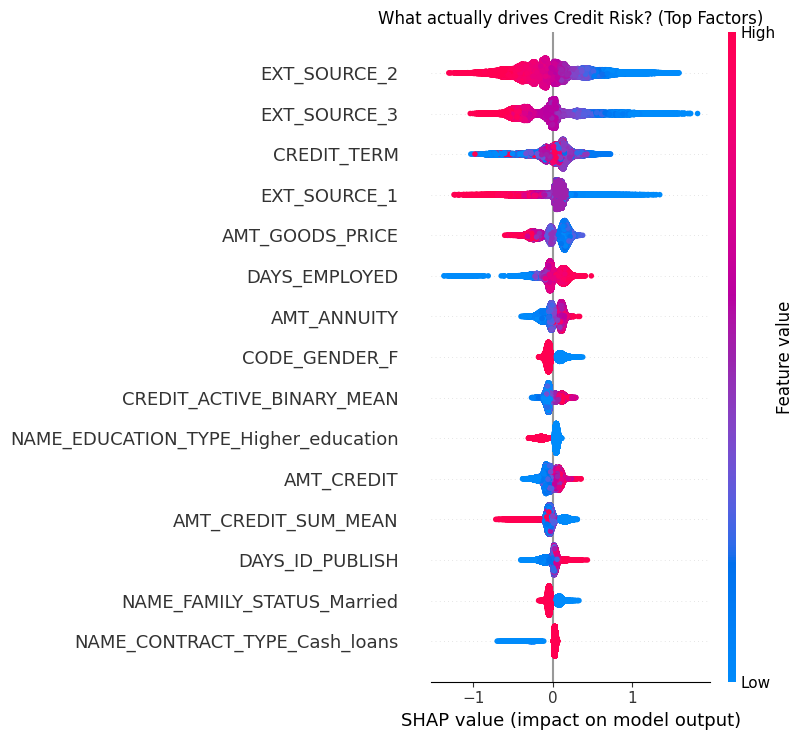

In [40]:
import shap
import matplotlib.pyplot as plt

# 1. Load the Best Model (The Bureau Boosted one)
model = joblib.load('../models/final_model_lgbm_boosted.joblib')

# 2. Create Explainer
# We use the TreeExplainer which is optimized for LightGBM
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 3. Handle the Array Issue
# (If shap_values comes back as a list, we pick index 1. If not, we use it directly)
if isinstance(shap_values, list):
    vals = shap_values[1]
else:
    vals = shap_values

# 4. PLOT THE SUMMARY
plt.figure(figsize=(10, 6))
plt.title("What actually drives Credit Risk? (Top Factors)")
shap.summary_plot(vals, X_test, plot_type="dot", max_display=15)